# Show scaledown is working
- show scaledown can find the same circles as the data with full amounts of input
- 3A: % circles
- 3B: n circles
- 3C: venn diagram with full datasets there
- 3D: CPM is correlated?

In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plot_params import *
from pathlib import Path
import numpy as np
circ_quant_output = []
indir = '/projects/ps-yeolab5/hsher/circ_outputs'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf')]

In [2]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [3]:
rename_dict = {
               #### included
                'circseq-bm-rz': 'rz_rep1', 
               'HEK_rz':'rz_rep2',
                'circseq-bm-rar': 'rar_rep1',
               'HEK_rar': 'rar_rep2', 
               
               'circseq-bm-arr': 'arr_rep1', 
               'HEK_arr':'arr_rep2',
               'circseq-bm-rar11-nxt': 'rar11_rep1', 
               'HEK_rar11': 'rar11_rep2', 
               '50_rar16_re': 'rar11(50ng)',
               '100_rar16_re':'rar11(100ng)',
                '200_rar14_re':'rar11(200ng)',
                '500_rar14_re':'rar11(500ng)'
               ### included
               }
group_color = {
                'rz':'lightgrey',
              'rar11': 'grey',
              'rar11(50ng)': 'tomato',
                'rar11(100ng)':'gold',
                'rar11(200ng)':'seagreen',
                'rar11(500ng)':'royalblue',
    'arr': 'black',
    'rar': 'darkviolet'
              }

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']
for fname in circ_quant_output:
    
    
    name = os.path.basename(fname).replace('.gtf', '')
    if name in rename_dict.keys():
        names.append(name)

        circ_df, stat = read_ciri_gtf(fname)

        circ_type_count.append(circ_df['circ_type'].value_counts())

        junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
        bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
        fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
        stats.append(stat.set_index(0))
        
        
        
    
        mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()


In [5]:
stats_df = pd.concat(stats, axis = 1).T
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

stats_df = stats_df.drop_duplicates('##Sample').set_index('##Sample')
stats_df = stats_df.rename(rename_dict).sort_index()
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

names = [rename_dict[c] if c in rename_dict.keys() else c for c in names ]



In [6]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names
counts = counts.T.reset_index().drop_duplicates('index').set_index('index')

In [7]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names
bsj=bsj.T.reset_index().drop_duplicates('index').set_index('index').T
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names
fsj=fsj.T.reset_index().drop_duplicates('index').set_index('index').T
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names
junc=junc.T.reset_index().drop_duplicates('index').set_index('index').T

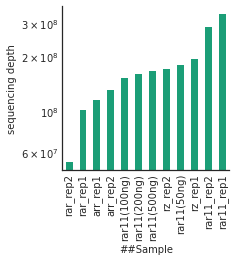

In [8]:
stats_df['##Total_Reads'].sort_values().plot.bar(figsize = (3,3))
plt.ylabel('sequencing depth')
plt.yscale('log')
sns.despine()
plt.savefig(figdir / '3S_scaledown_seq_depth.pdf')

In [9]:
list(rename_dict.values())

['rz_rep1',
 'rz_rep2',
 'rar_rep1',
 'rar_rep2',
 'arr_rep1',
 'arr_rep2',
 'rar11_rep1',
 'rar11_rep2',
 'rar11(50ng)',
 'rar11(100ng)',
 'rar11(200ng)',
 'rar11(500ng)']

In [10]:
figure1_sets = [
 'rar11(50ng)',
 'rar11(100ng)',
 'rar11(200ng)',
 'rar11(500ng)',
'rar11_rep1',
 'rar11_rep2']

In [11]:
figure1_colors = [group_color[c.split('-')[0].split('_rep')[0]] for c in figure1_sets]

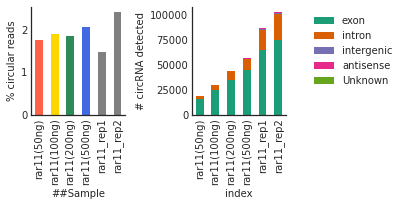

In [12]:
f, ax = plt.subplots(1,2, figsize = (6,3))
(stats_df.loc[figure1_sets, 'frac_circular']*100).plot.bar(
    color = figure1_colors, ax = ax[0])
ax[0].set_ylabel('% circular reads')




counts.loc[figure1_sets].plot.bar(stacked = True, ax = ax[1])
ax[1].set_ylabel('# circRNA detected')
ax[1].legend(bbox_to_anchor = (1.2,1))
sns.despine()
plt.tight_layout()
plt.savefig(figdir / '3_scaledown_perc_circle.pdf')

# Enrichment as measured by junction ratio

In [13]:
from scipy.stats import pearsonr

In [14]:
sub_junc = junc.loc[~(junc['rar11_rep1'].isnull())&~(junc['rar11_rep2'].isnull())]
sub_junc_t = sub_junc.T.copy()
sub_junc_t['protocol']=pd.Series(sub_junc.columns).str.split('_', expand = True)[0].tolist()
avg_junc = sub_junc_t.groupby(by = 'protocol').mean().T

In [15]:
figure1_sets

['rar11(50ng)',
 'rar11(100ng)',
 'rar11(200ng)',
 'rar11(500ng)',
 'rar11_rep1',
 'rar11_rep2']

In [16]:
(~avg_junc.isnull().any()).sum()

1

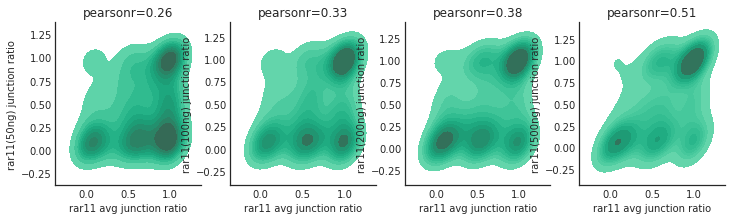

In [17]:
f, axes = plt.subplots(1,4, figsize = (12,3))
for protocol, ax in zip([i for i in figure1_sets if 'ng' in i], axes):
    
    non_nan = avg_junc.loc[~avg_junc[protocol].isnull()]
    if non_nan.shape[0]>500:
        non_nan = non_nan.sample(500)
    sns.kdeplot(data = non_nan, x = f'rar11', y = f'{protocol}', fill = True, ax = ax)
    ax.set_xlabel(f'rar11 avg junction ratio')
    ax.set_ylabel(f'{protocol} junction ratio')
    
    r,p = pearsonr(non_nan[f'{protocol}'],non_nan[f'rar11'])
    ax.set_title(f'pearsonr={r:.2f}')
sns.despine()
plt.savefig(figdir / '3_junc_ratio_vs_scaledown.pdf')

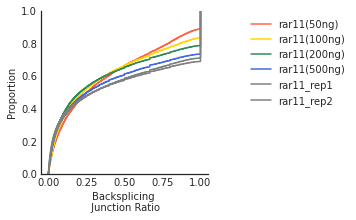

In [18]:
f, ax = plt.subplots(figsize = (3,3))
for col, color in zip(figure1_sets, figure1_colors):
    ax = sns.ecdfplot(data =junc[col].to_frame(), x = col, ax = ax, label = col, color = color)
    ax.set_xlabel('Backsplicing \n Junction Ratio')
ax.legend(bbox_to_anchor = (1.2,1))
#sns.move_legend(ax, "center right")
sns.despine()

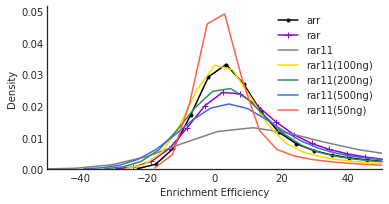

In [19]:
enrichment_eff = avg_junc.loc[avg_junc['rz']>0].div(avg_junc.loc[avg_junc['rz']>0, 'rz'], axis = 0)
f, ax = plt.subplots(figsize = (6,3))
for protocol in [c for c in enrichment_eff.columns if c!='rz']:
    if protocol == 'rar':
        marker = '+'
        alpha = 0.5
    elif protocol == 'arr':
        marker = '.'
        alpha = 0.5
    else:
        marker = None
        alpha = 1
    sns.kdeplot(data = enrichment_eff.fillna(0), x = protocol, label = protocol, ax = ax,
               color = group_color[protocol], marker = marker, alpha = alpha)
ax.legend()
ax.set_xlabel('Enrichment Efficiency')
ax.set_xlim(-50,50)
sns.despine()
plt.savefig(figdir / '3_enrichment_eff.pdf')

# Accuracy

In [20]:
circname = {}
for name in bsj.columns:
    circname[name] = set(bsj[name].dropna().index)

In [21]:
circname.keys()

dict_keys(['rz_rep1', 'rar11_rep1', 'rar11(100ng)', 'rar_rep1', 'rar11(50ng)', 'rar11(500ng)', 'rar_rep2', 'arr_rep2', 'arr_rep1', 'rar11_rep2', 'rar11(200ng)', 'rz_rep2'])

In [22]:
circname_reproducible = {}
for protocol in ['rar11']:
    circname_reproducible[protocol]=circname[f'{protocol}_rep1'].intersection(circname[f'{protocol}_rep2'])
for lbl in [i for i in figure1_sets if 'ng' in i]:
    circname_reproducible[lbl]=circname[lbl]

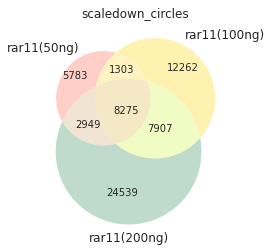

In [23]:
from matplotlib_venn import venn3
labels = [i for i in figure1_sets if 'ng' in i]
venn3([circname[p] for p in labels[:-1]]
      , set_labels = tuple(labels[:-1]), 
      set_colors = (group_color[p] for p in labels[:-1]),
      alpha = 0.3
     )
plt.title('scaledown_circles')
plt.savefig(figdir / '3_venn_3concentration-1.pdf')

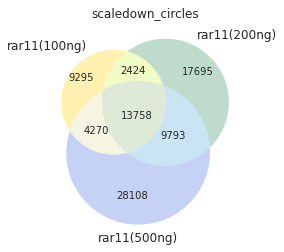

In [24]:
venn3([circname[p] for p in labels[1:]]
      , set_labels = tuple(labels[1:]), 
      set_colors = (group_color[p] for p in labels[1:]),
      alpha = 0.3
     )
plt.title('scaledown_circles')
plt.savefig(figdir / '3_venn_3concentration-2.pdf')

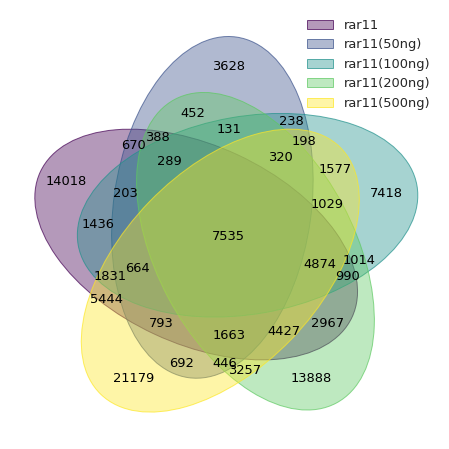

In [25]:
from venn import venn
venn(circname_reproducible)
plt.savefig(figdir / '3_venn_5procotol.pdf')

In [26]:
# percent reproducible circles recovered from rar11 replicates

In [27]:

detected_t = ~bsj.isnull().T
detected_t['protocol']=pd.Series(bsj.columns).str.split('_', expand = True)[0].tolist()
detected_both = detected_t.groupby(by = 'protocol').all().T
detected_both.columns = ['detected_'+c for c in detected_both.columns]


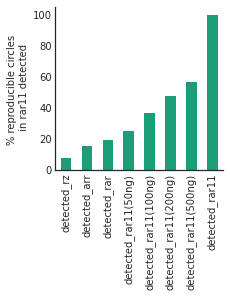

In [28]:
(detected_both.loc[detected_both['detected_rar11']].mean(axis = 0)*100).sort_values(
    ).plot.bar(figsize = (3,3))
plt.ylabel('% reproducible circles \n in rar11 detected')
sns.despine()
plt.savefig(figdir / '3_perc_detected_inrar11.pdf')

In [29]:
from scipy.stats import pearsonr
def get_pearsonr_dropna(df, col1, col2):
    sub = df[[col1, col2]].dropna()
    r,p=pearsonr(sub[col1], sub[col2])
    return r,p

In [30]:
cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

In [31]:
cpm_t = cpm.loc[(cpm['rz_rep1']>0)&(cpm['rz_rep2']>0)].T.copy()
cpm_t['protocol']=pd.Series(cpm.columns).str.split('_', expand = True)[0].tolist()
avg_cpm = cpm_t.groupby(by = 'protocol').mean().T

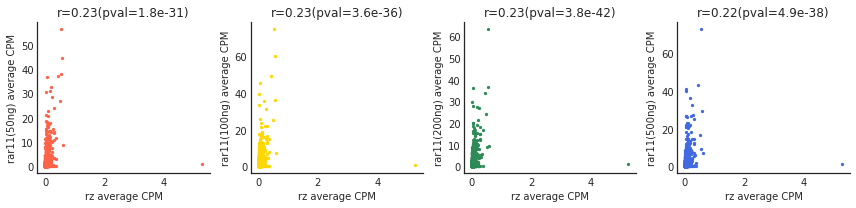

In [32]:
f, axes = plt.subplots(1,4, figsize = (12,3))
for protocol, ax in zip(figure1_sets, axes.flatten()):

    avg_cpm.plot.scatter(y = f'{protocol}', x = f'rz', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(avg_cpm, f'{protocol}', f'rz')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'rz average CPM')
    ax.set_ylabel(f'{protocol} average CPM')


plt.tight_layout()
sns.despine()
plt.savefig(figdir / '3_scaledown_CPM_corr_w_rz.pdf')

In [33]:
cpm_t = cpm.T.copy()
cpm_t['protocol']=pd.Series(cpm.columns).str.split('_', expand = True)[0].tolist()
avg_cpm = cpm_t.groupby(by = 'protocol').mean().T

In [34]:
bsj.shape, cpm.shape

((203534, 12), (203534, 12))

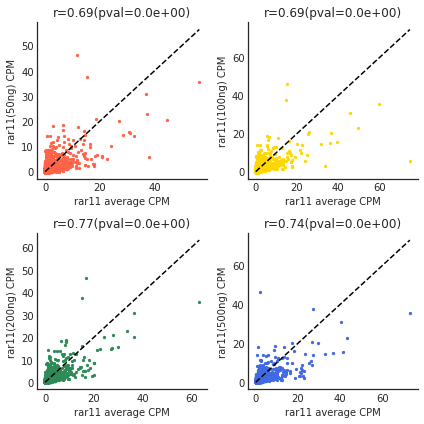

In [35]:
f, axes = plt.subplots(2,2, figsize = (6,6))
for protocol, ax in zip(figure1_sets, axes.flatten()):

    avg_cpm.plot.scatter(x = f'{protocol}', y = f'rar11', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(avg_cpm, f'{protocol}', f'rar11')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'rar11 average CPM')
    ax.set_ylabel(f'{protocol} CPM')
    ax.plot([0, max(avg_cpm[protocol].max(), avg_cpm['rar11'].max())],
            [0, max(avg_cpm[protocol].max(), avg_cpm['rar11'].max())],
            '--',
            color = 'black'
           )


plt.tight_layout()
sns.despine()
plt.savefig(figdir / '3_CPM_corr_w_rar11.pdf')

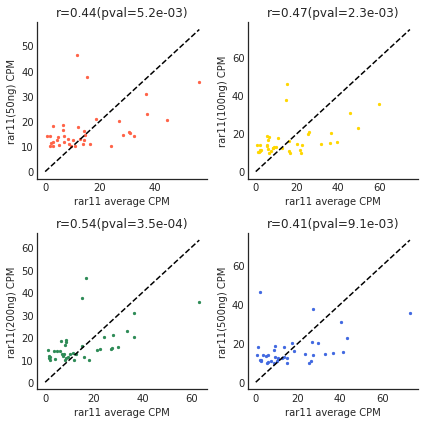

In [36]:
f, axes = plt.subplots(2,2, figsize = (6,6))
for protocol, ax in zip(figure1_sets, axes.flatten()):
    highexp = avg_cpm.loc[avg_cpm['rar11']>10]
    highexp.plot.scatter(x = f'{protocol}', y = f'rar11', ax = ax, 
                     color = group_color[protocol], marker = '.')
    r,p = get_pearsonr_dropna(highexp, f'{protocol}', f'rar11')
    ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'rar11 average CPM')
    ax.set_ylabel(f'{protocol} CPM')
    ax.plot([0, max(avg_cpm[protocol].max(), avg_cpm['rar11'].max())],
            [0, max(avg_cpm[protocol].max(), avg_cpm['rar11'].max())],
            '--',
            color = 'black'
           )


plt.tight_layout()
sns.despine()
#plt.savefig(figdir / '3_CPM_corr_w_rar11.pdf')

In [37]:
bsj.columns

Index(['rz_rep1', 'rar11_rep1', 'rar11(100ng)', 'rar_rep1', 'rar11(50ng)',
       'rar11(500ng)', 'rar_rep2', 'arr_rep2', 'arr_rep1', 'rar11_rep2',
       'rar11(200ng)', 'rz_rep2'],
      dtype='object', name='index')

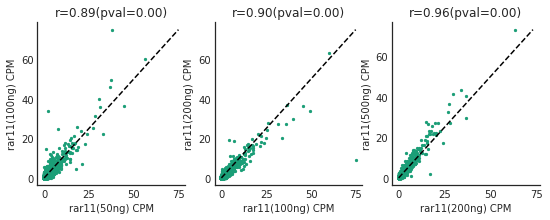

In [38]:
f, axes = plt.subplots(1,3, figsize = (9,3))
for protocol1, protocol2, ax in zip(figure1_sets[:-1], figure1_sets[1:], axes.flatten()):
    cpm.plot.scatter(x = protocol1, y = protocol2, ax = ax, 
                     marker = '.')
    r,p = get_pearsonr_dropna(cpm, protocol1, protocol2)
    ax.set_title(f'r={r:.2f}(pval={p:.2f})')
    ax.set_xlabel(f'{protocol1} CPM')
    ax.set_ylabel(f'{protocol2} CPM')
    ax.plot([0, max(avg_cpm[protocol1].max(), avg_cpm[protocol2].max())],
            [0, max(avg_cpm[protocol1].max(), avg_cpm[protocol2].max())],
            '--',
            color = 'black'
           )
sns.despine()

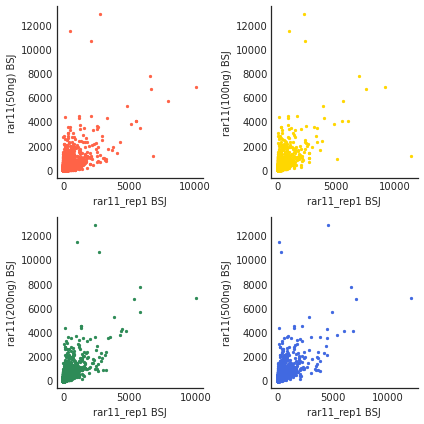

In [39]:
f, axes = plt.subplots(2,2, figsize = (6,6))
for protocol, ax in zip(figure1_sets, axes.flatten()):

    bsj.plot.scatter(x = f'{protocol}', y = f'rar11_rep1', ax = ax, 
                     color = group_color[protocol], marker = '.')
    # r,p = get_pearsonr_dropna(avg_cpm, f'{protocol}', f'rar11')
    #ax.set_title(f'r={r:.2f}(pval={p:.1e})')
    ax.set_xlabel(f'rar11_rep1 BSJ')
    ax.set_ylabel(f'{protocol} BSJ')


plt.tight_layout()
sns.despine()
plt.savefig(figdir / '3_BSJ_corr_w_rar11.pdf')

In [40]:
mionco_df = pd.read_csv('/projects/ps-yeolab5/hsher/mioncocirc/v0.1.release.txt', sep = '\t')
mionco_df['circ_id']=mionco_df['chr']+':'+(mionco_df['start']+1).astype(str)+'|'+mionco_df['end'].astype(str)

In [41]:
mega = pd.concat([detected_both, cpm, mega_anno], axis = 1)
mega['is_miOncoCirc']=mega.index.isin(mionco_df['circ_id'])

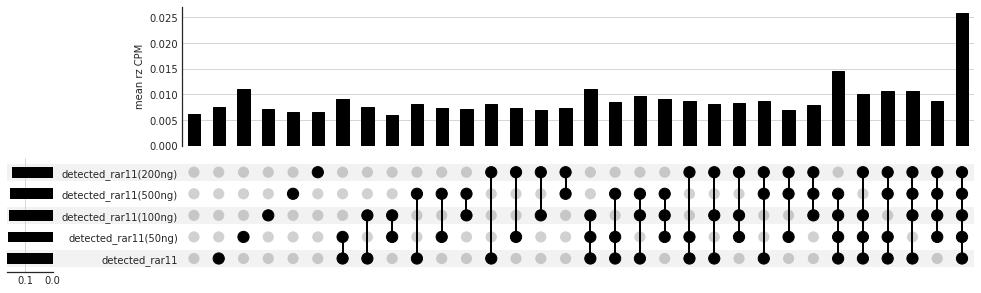

In [42]:
from upsetplot import plot
plot(mega.groupby(by = [c for c in mega.columns if c.startswith('detected_') and 'rar11' in c])['rz_rep1'].mean(),
    )
plt.ylabel('mean rz CPM')
plt.savefig(figdir / '3_scaledown_mean_CPM_upset.pdf')

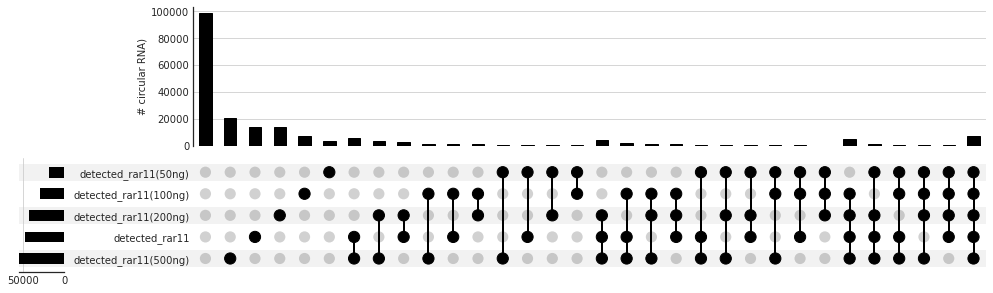

In [43]:

plot(mega.groupby(by = [c for c in mega.columns if c.startswith('detected_') and 'rar11' in c]).count()['gene_name'],
    )
plt.ylabel('# circular RNA)')
plt.savefig(figdir / '3_count_circRNA.pdf')

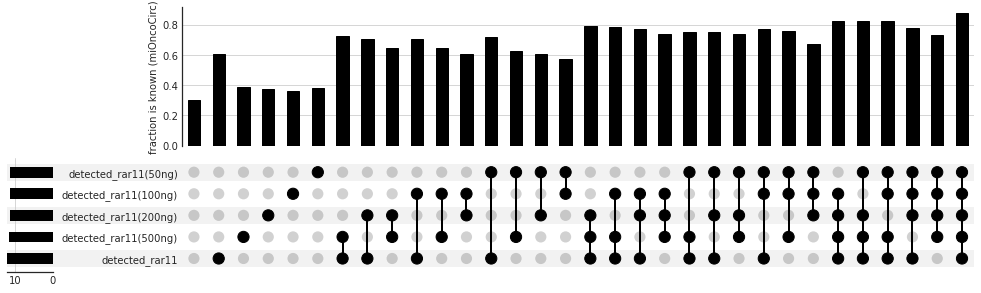

In [44]:

plot(mega.groupby(by = [c for c in mega.columns if c.startswith('detected_') and 'rar11' in c])['is_miOncoCirc'].mean(),
    )
plt.ylabel('fraction is known (miOncoCirc)')
plt.savefig(figdir / '3_fraction_miOncoCirc.pdf')

# Downsampling

In [45]:
from pathlib import Path
downsample_dir = Path('/home/hsher/scratch/downsample_ciri/output/')

In [46]:
data = []
for fname in downsample_dir.glob('*.gtf'):
    name, depth,_ = fname.name.split('.')
    if 'rar11' in name or '0_rar' in name:
        depth = int(depth)
        circ_df, stat = read_ciri_gtf(fname)
        cnt = circ_df['circ_type'].value_counts()
        value = pd.concat([stat.set_index(0)[1], cnt])
        value['name'] = name
        value['depth']=depth
        data.append(value)
data = pd.concat(data, axis =1).T

In [47]:
data[[ '##Total_Reads',
 '##Mapped_Reads',
 '##Circular_Reads']]=data[[ '##Total_Reads',
 '##Mapped_Reads',
 '##Circular_Reads']].astype(int)

In [48]:
group_color

{'rz': 'lightgrey',
 'rar11': 'grey',
 'rar11(50ng)': 'tomato',
 'rar11(100ng)': 'gold',
 'rar11(200ng)': 'seagreen',
 'rar11(500ng)': 'royalblue',
 'arr': 'black',
 'rar': 'darkviolet'}

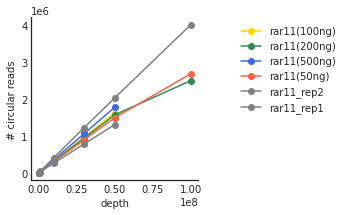

In [49]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    group.plot(x = 'depth', y = '##Circular_Reads', ax = ax, 
               label = rename_dict[name], marker = 'o',
              color =group_color[rename_dict[name].split('_')[0]])
    sns.despine()
ax.set_ylabel('# circular reads')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_circ_read.pdf')

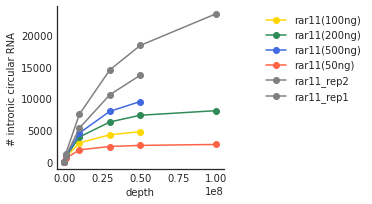

In [50]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    group.plot(x = 'depth', y = 'intron', ax = ax, 
               label = rename_dict[name], marker = 'o',
              color =group_color[rename_dict[name].split('_')[0]])
    sns.despine()
ax.set_ylabel('# intronic circular RNA')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_intronic_circ.pdf')

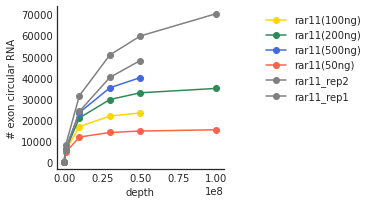

In [51]:
f,ax = plt.subplots(figsize = (3,3))
for name, group in data.sort_values(by = 'depth').groupby(by = 'name'):
    group.plot(x = 'depth', y = 'exon', ax = ax, 
               label = rename_dict[name], marker = 'o',
              color =group_color[rename_dict[name].split('_')[0]])
    sns.despine()
ax.set_ylabel('# exon circular RNA')
ax.legend(bbox_to_anchor = (1.2, 1))
plt.savefig(figdir / '1_downsample_n_exonic_circ.pdf')